In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
import splitfolders
import matplotlib.pyplot as plt
import shutil

from ultralytics import YOLO

In [2]:
def rm_folder_if_exists(folder):
    if os.path.exists(folder):
        try:
            shutil.rmtree(folder)
        except OSError as e:
            print("Error: %s - %s." % (e.filename, e.strerror))

In [3]:
def draw_yolo_labels(img, label_path, imgsz=1024):
    orig_h, orig_w = img.shape[:2]
    scale = min(imgsz / orig_w, imgsz / orig_h)
    resized_w, resized_h = int(orig_w * scale), int(orig_h * scale)
    pad_x = (imgsz - resized_w) // 2
    pad_y = (imgsz - resized_h) // 2

    with open(label_path, 'r') as f:
        for line in f:
            if not line.strip():
                continue
            cls, xc, yc, bw, bh = map(float, line.strip().split())

            x_center = xc * imgsz
            y_center = yc * imgsz
            box_w = bw * imgsz
            box_h = bh * imgsz

            x_center -= pad_x
            y_center -= pad_y

            x_center /= scale
            y_center /= scale
            box_w /= scale
            box_h /= scale

            x1 = int(x_center - box_w / 2)
            y1 = int(y_center - box_h / 2)
            x2 = int(x_center + box_w / 2)
            y2 = int(y_center + box_h / 2)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return img

In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"Setup complete. Using torch {torch.__version__} ({DEVICE})")

Setup complete. Using torch 2.6.0+cu124 (cuda:0)


In [4]:
splitfolders.ratio('./HumanDetection/heridal', output='./HumanDetection/heridal_split/images',
                seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 1546 files [00:04, 325.03 files/s]


In [5]:
TRAIN_DATA_DIR = './HumanDetection/heridal_split/images/train/class0'
VAL_DATA_DIR = './HumanDetection/heridal_split/images/val/class0'

IMG_WIDTH = 4000
IMG_HEIGHT = 3000

EPOCHS = 100

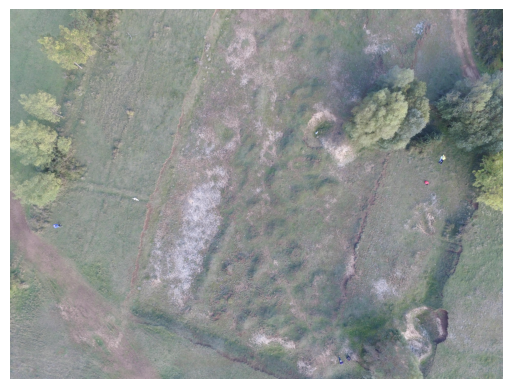

In [9]:
test_img = TRAIN_DATA_DIR + '/train_BLA_0002_JPG.rf.1e82cab69709e084d88eed66b0aa2a88.jpg' 

img = cv2.imread(test_img)
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [10]:
df = pd.read_csv('./HumanDetection/heridal/_annotations.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,train_BRA_1012_JPG.rf.fa0e8bf1e58b462173e12dd6...,4000,3000,human,754,1012,791,1046
1,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,human,1910,1258,1949,1294
2,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,human,966,1900,1016,1931
3,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,human,1564,2624,1604,2676
4,train_BRK_2092_JPG.rf.fc6ba9e5aa512819b66ef089...,4000,3000,human,2578,1010,2658,1079


In [11]:
df = df.replace('human', 0)
df.head()

/tmp/ipykernel_2153840/1064772545.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('human', 0)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,train_BRA_1012_JPG.rf.fa0e8bf1e58b462173e12dd6...,4000,3000,0,754,1012,791,1046
1,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,0,1910,1258,1949,1294
2,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,0,966,1900,1016,1931
3,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,0,1564,2624,1604,2676
4,train_BRK_2092_JPG.rf.fc6ba9e5aa512819b66ef089...,4000,3000,0,2578,1010,2658,1079


In [12]:
print(df['class'].unique())
print(df['width'].unique())
print(df['height'].unique())

[0]
[4000]
[3000]


In [13]:
LABELS_DIR_TRAIN = './HumanDetection/heridal_split/labels/train/class0'
LABELS_DIR_VAL = './HumanDetection/heridal_split/labels/val/class0'
os.makedirs(LABELS_DIR_TRAIN, exist_ok=True)
os.makedirs(LABELS_DIR_VAL, exist_ok=True)

In [10]:
grouped = df.groupby('filename')

for filename, group in grouped:
    img_train = os.path.join(TRAIN_DATA_DIR, filename)

    if os.path.exists(img_train):
        txt_path = os.path.join(LABELS_DIR_TRAIN, os.path.splitext(filename)[0] + '.txt')
    else:
        txt_path = os.path.join(LABELS_DIR_VAL, os.path.splitext(filename)[0] + '.txt')

    with open(txt_path, 'w') as f:
        for _, row in group.iterrows():
            class_id = row['class']
            x_center = ((row['xmin'] + row['xmax']) / 2) / IMG_WIDTH
            y_center = ((row['ymin'] + row['ymax']) / 2) / IMG_HEIGHT
            width = (row['xmax'] - row['xmin']) / IMG_WIDTH
            height = (row['ymax'] - row['ymin']) / IMG_HEIGHT
            
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

In [11]:
with open('./HumanDetection/heridal_split/labels/train/class0/train_BLA_0002_JPG.rf.1e82cab69709e084d88eed66b0aa2a88.txt', 'r') as f:
    print(f.read())

0 0.096875 0.586167 0.018750 0.014333
0 0.670000 0.948667 0.012500 0.024667
0 0.876500 0.407833 0.014500 0.029667



In [12]:
rm_folder_if_exists('./runs/detect/yolo11s_heridal')

In [ ]:
model = YOLO('yolo11s.pt')

results = model.train(
    data='./HumanDetection/heridal.yaml',
    epochs=200,
    device=DEVICE,
    imgsz=960,
    batch=8,
    optimizer='Adam',
    name='yolo11s_heridal',
    workers=1,
)

New https://pypi.org/project/ultralytics/8.3.140 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./HumanDetection/heridal.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11s_heridal, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, p

train: Scanning /home/capybariana/jupyter-labs/HumanDetection/heridal_split/labels/train/class0.cache... 788 images, 448 backgrounds, 0 corrupt: 100%|██████████| 1236/1236 [00:00<?, ?it/s


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 745.5±196.9 MB/s, size: 3501.9 KB)


val: Scanning /home/capybariana/jupyter-labs/HumanDetection/heridal_split/labels/val/class0.cache... 197 images, 113 backgrounds, 0 corrupt: 100%|██████████| 310/310 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo11s_heridal/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolo11s_heridal
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.16G      2.822      24.24      1.009          4        640: 100%|██████████| 155/155 [00:11<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 16.65it/s]


                   all        310        574       0.48      0.449      0.359      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200       2.3G      2.904      2.345     0.9993          7        640: 100%|██████████| 155/155 [00:11<00:00, 14.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 16.47it/s]


                   all        310        574     0.0228      0.568     0.0173    0.00567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.31G      2.805      2.113     0.9856         32        640: 100%|██████████| 155/155 [00:10<00:00, 14.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 19.72it/s]


                   all        310        574      0.434      0.328      0.282     0.0763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.35G      2.774      2.081      1.002          2        640: 100%|██████████| 155/155 [00:10<00:00, 14.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:00<00:00, 20.75it/s]

                   all        310        574     0.0817      0.476     0.0567     0.0171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.38G      2.828      2.139          1         22        640:  66%|██████▌   | 102/155 [00:07<00:03, 13.85it/s]
Exception in thread Thread-8 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/capybariana/venvs/jupyter/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/capybariana/venvs/jupyter/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/home/capybariana/venvs/jupyter/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickle

KeyboardInterrupt: 

    148/200      7.76G      1.585     0.9389     0.9137         63       1024: 100%|██████████| 103/103 [01:14<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        310        574      0.762      0.737      0.806      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      7.71G      1.555     0.9059     0.9217         28       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

                   all        310        574      0.787      0.746      0.813      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      7.71G      1.583     0.9264      0.917         41       1024: 100%|██████████| 103/103 [01:10<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

                   all        310        574      0.707      0.667      0.735      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      7.72G      1.576     0.9085     0.9182         37       1024: 100%|██████████| 103/103 [01:13<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

                   all        310        574      0.747      0.692      0.763      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      7.71G      1.609     0.9338     0.9276         13       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        310        574      0.711      0.727      0.765        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      7.75G      1.567     0.9114      0.933         13       1024: 100%|██████████| 103/103 [01:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        310        574      0.733      0.711      0.764      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      7.71G      1.544     0.9068       0.92         19       1024: 100%|██████████| 103/103 [01:13<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

                   all        310        574      0.753      0.706       0.76      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      7.68G      1.574     0.9291     0.9096         47       1024: 100%|██████████| 103/103 [01:13<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

                   all        310        574      0.764      0.726      0.785      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200       7.7G      1.544     0.9362     0.9137         31       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

                   all        310        574      0.761       0.74      0.795      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      7.68G      1.584     0.9282     0.9172         13       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

                   all        310        574      0.724      0.713      0.754      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      7.77G      1.571     0.9356      0.915         17       1024: 100%|██████████| 103/103 [01:13<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

                   all        310        574      0.784      0.719        0.8      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      7.72G      1.515     0.8706     0.9041         29       1024: 100%|██████████| 103/103 [01:12<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        310        574      0.808      0.688      0.796      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      7.71G      1.545     0.9071     0.9067         22       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

                   all        310        574       0.71      0.699      0.754       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      7.71G      1.532     0.9018      0.914         14       1024: 100%|██████████| 103/103 [01:12<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        310        574      0.747      0.694      0.766      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      7.94G       1.53     0.9014     0.9077         10       1024: 100%|██████████| 103/103 [01:13<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]

                   all        310        574      0.804      0.742      0.812      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      7.73G      1.539     0.8975     0.9121         25       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        310        574       0.78      0.721      0.793      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      7.71G      1.532     0.8891     0.9062         42       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

                   all        310        574      0.807      0.684      0.795      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      7.68G      1.484     0.8638     0.9097         39       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]

                   all        310        574      0.764      0.741      0.805      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      7.74G      1.515     0.8783     0.9099         29       1024: 100%|██████████| 103/103 [01:13<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        310        574      0.758      0.692      0.766       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      7.72G      1.488     0.8354     0.9035         79       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]

                   all        310        574      0.767      0.732      0.793      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      7.75G      1.505     0.8521     0.9046         65       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

                   all        310        574      0.768      0.676      0.782      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      7.73G       1.44     0.8357     0.8937         23       1024: 100%|██████████| 103/103 [01:11<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

                   all        310        574      0.769      0.712      0.786      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      7.77G       1.53     0.8999     0.9017         11       1024: 100%|██████████| 103/103 [01:11<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        310        574       0.75       0.73      0.791      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200       7.7G      1.483     0.8614     0.9039         55       1024: 100%|██████████| 103/103 [01:12<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

                   all        310        574      0.767      0.713      0.787      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      7.76G       1.46     0.8319     0.9007         22       1024: 100%|██████████| 103/103 [01:10<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.23it/s]

                   all        310        574      0.757       0.71      0.777      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      7.68G      1.466      0.852     0.9045         30       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        310        574      0.729      0.782      0.803       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      7.76G      1.478     0.8597     0.9002         28       1024: 100%|██████████| 103/103 [01:13<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

                   all        310        574      0.768      0.746      0.813       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      7.75G      1.458     0.8508     0.8983         34       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]

                   all        310        574      0.779      0.755      0.813      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      7.75G      1.453     0.8198      0.901         17       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        310        574      0.749      0.748      0.804       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      7.76G       1.45     0.8117     0.8972         29       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        310        574       0.75      0.706      0.789      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      7.83G      1.463     0.8293     0.8928         32       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        310        574      0.761      0.732      0.795      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      7.72G       1.44     0.8119     0.8954         30       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

                   all        310        574       0.78      0.746      0.823      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      7.68G      1.452     0.8147     0.8986         26       1024: 100%|██████████| 103/103 [01:13<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

                   all        310        574      0.777      0.713      0.799      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      7.71G      1.495     0.8404     0.9072         30       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

                   all        310        574      0.752      0.761      0.815      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      7.68G       1.43     0.7946     0.8917         25       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

                   all        310        574      0.766      0.772      0.824      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      7.71G      1.406     0.8195     0.8992         35       1024: 100%|██████████| 103/103 [01:14<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

                   all        310        574      0.755       0.67      0.749      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      7.76G      1.415     0.8164     0.8971         60       1024: 100%|██████████| 103/103 [01:13<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        310        574      0.738      0.753      0.794      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      7.68G      1.438     0.8256     0.8959         39       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.27it/s]

                   all        310        574      0.787      0.721      0.803      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      7.69G      1.412     0.7934     0.8945         22       1024: 100%|██████████| 103/103 [01:13<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

                   all        310        574      0.805       0.69      0.792      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      7.76G      1.446     0.8332     0.9006         40       1024:  47%|████▋     | 48/103 [00:33<00:39,  1.38it/s]

In [14]:
best_model = YOLO('./runs/detect/yolo11s_heridal4/weights/last.pt')

In [14]:
rm_folder_if_exists('./runs/detect/val')

metrics = best_model.val()
print("\nValidation Metrics:")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")

Ultralytics 8.3.127 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 11980MiB)


YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 10047.3±702.9 MB/s, size: 2793.8 KB)


val: Scanning /home/capybariana/jupyter-labs/HumanDetection/heridal_split/labels/val/class0.cache... 197 images, 113 backgrounds, 0 corrupt: 100%|██████████| 310/310 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:04<00:00,  4.71it/s]


                   all        310        574      0.805       0.69      0.792      0.419
Speed: 1.0ms preprocess, 5.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val

Validation Metrics:
Precision: 0.8047
Recall: 0.6899
mAP50: 0.7916
mAP50-95: 0.4188


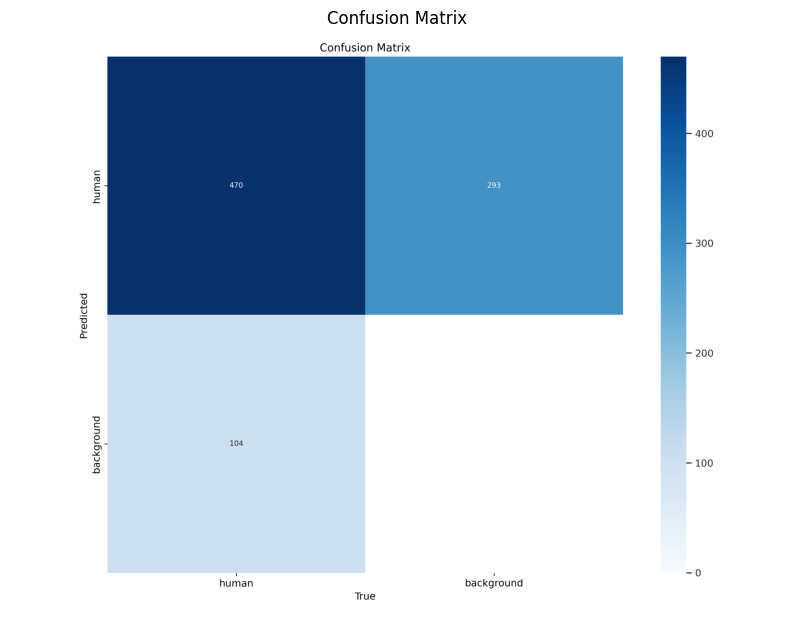

In [16]:
from PIL import Image
%matplotlib inline

confusion_matrix = Image.open('./runs/detect/val/confusion_matrix.png')
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix)
plt.title('Confusion Matrix')
plt.axis('off')
plt.show()

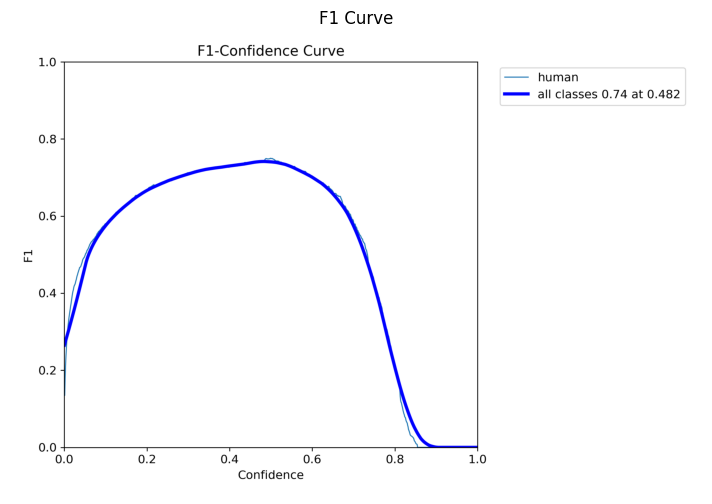

In [17]:
f1_curve = Image.open('./runs/detect/val/F1_curve.png')
plt.figure(figsize=(10, 6))
plt.imshow(f1_curve)
plt.title('F1 Curve')
plt.axis('off')
plt.show()

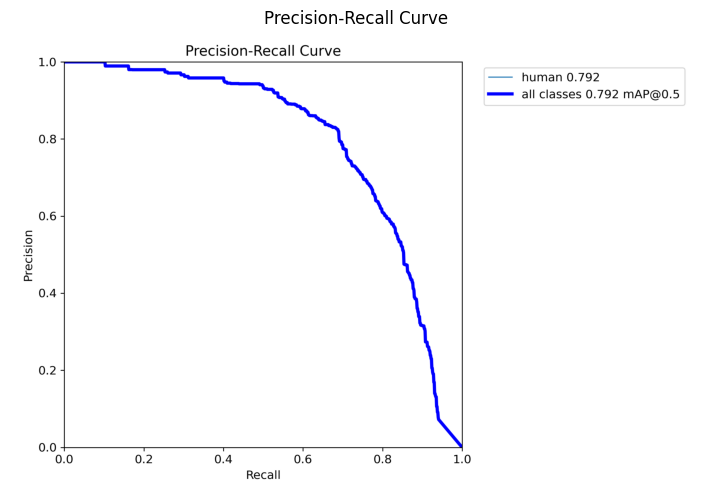

In [18]:
pr_curve = Image.open('./runs/detect/val/PR_curve.png')
plt.figure(figsize=(10, 6))
plt.imshow(pr_curve)
plt.title('Precision-Recall Curve')
plt.axis('off')
plt.show()

image 1/1 /home/capybariana/jupyter-labs/HumanDetection/heridal_split/images/val/class0/train_GOR_2018_JPG.rf.e636d888595d2d7d174692f5619920ba.jpg: 768x1024 (no detections), 4.8ms
Speed: 16.7ms preprocess, 4.8ms inference, 0.3ms postprocess per image at shape (1, 3, 768, 1024)
0 0.263375 0.844833 0.013750 0.013667
0 0.276250 0.817833 0.011500 0.018333
0 0.386250 0.790667 0.020000 0.016667
0 0.539000 0.274000 0.015500 0.014667
0 0.540750 0.257667 0.017000 0.020000
0 0.260625 0.077167 0.015250 0.025000
0 0.224000 0.075000 0.023500 0.030000
0 0.203000 0.012667 0.014000 0.022000
0 0.197500 0.056333 0.020500 0.030000


image 1/1 /home/capybariana/jupyter-labs/HumanDetection/heridal_split/images/val/class0/train_JAS_0084_JPG.rf.d8c622b811474f8af671a52b6be6251c.jpg: 768x1024 1 human, 4.8ms
Speed: 2.8ms preprocess, 4.8ms inference, 0.6ms postprocess per image at shape (1, 3, 768, 1024)
0 0.319875 0.606667 0.014250 0.022000


image 1/1 /home/capybariana/jupyter-labs/HumanDetection/heridal_split

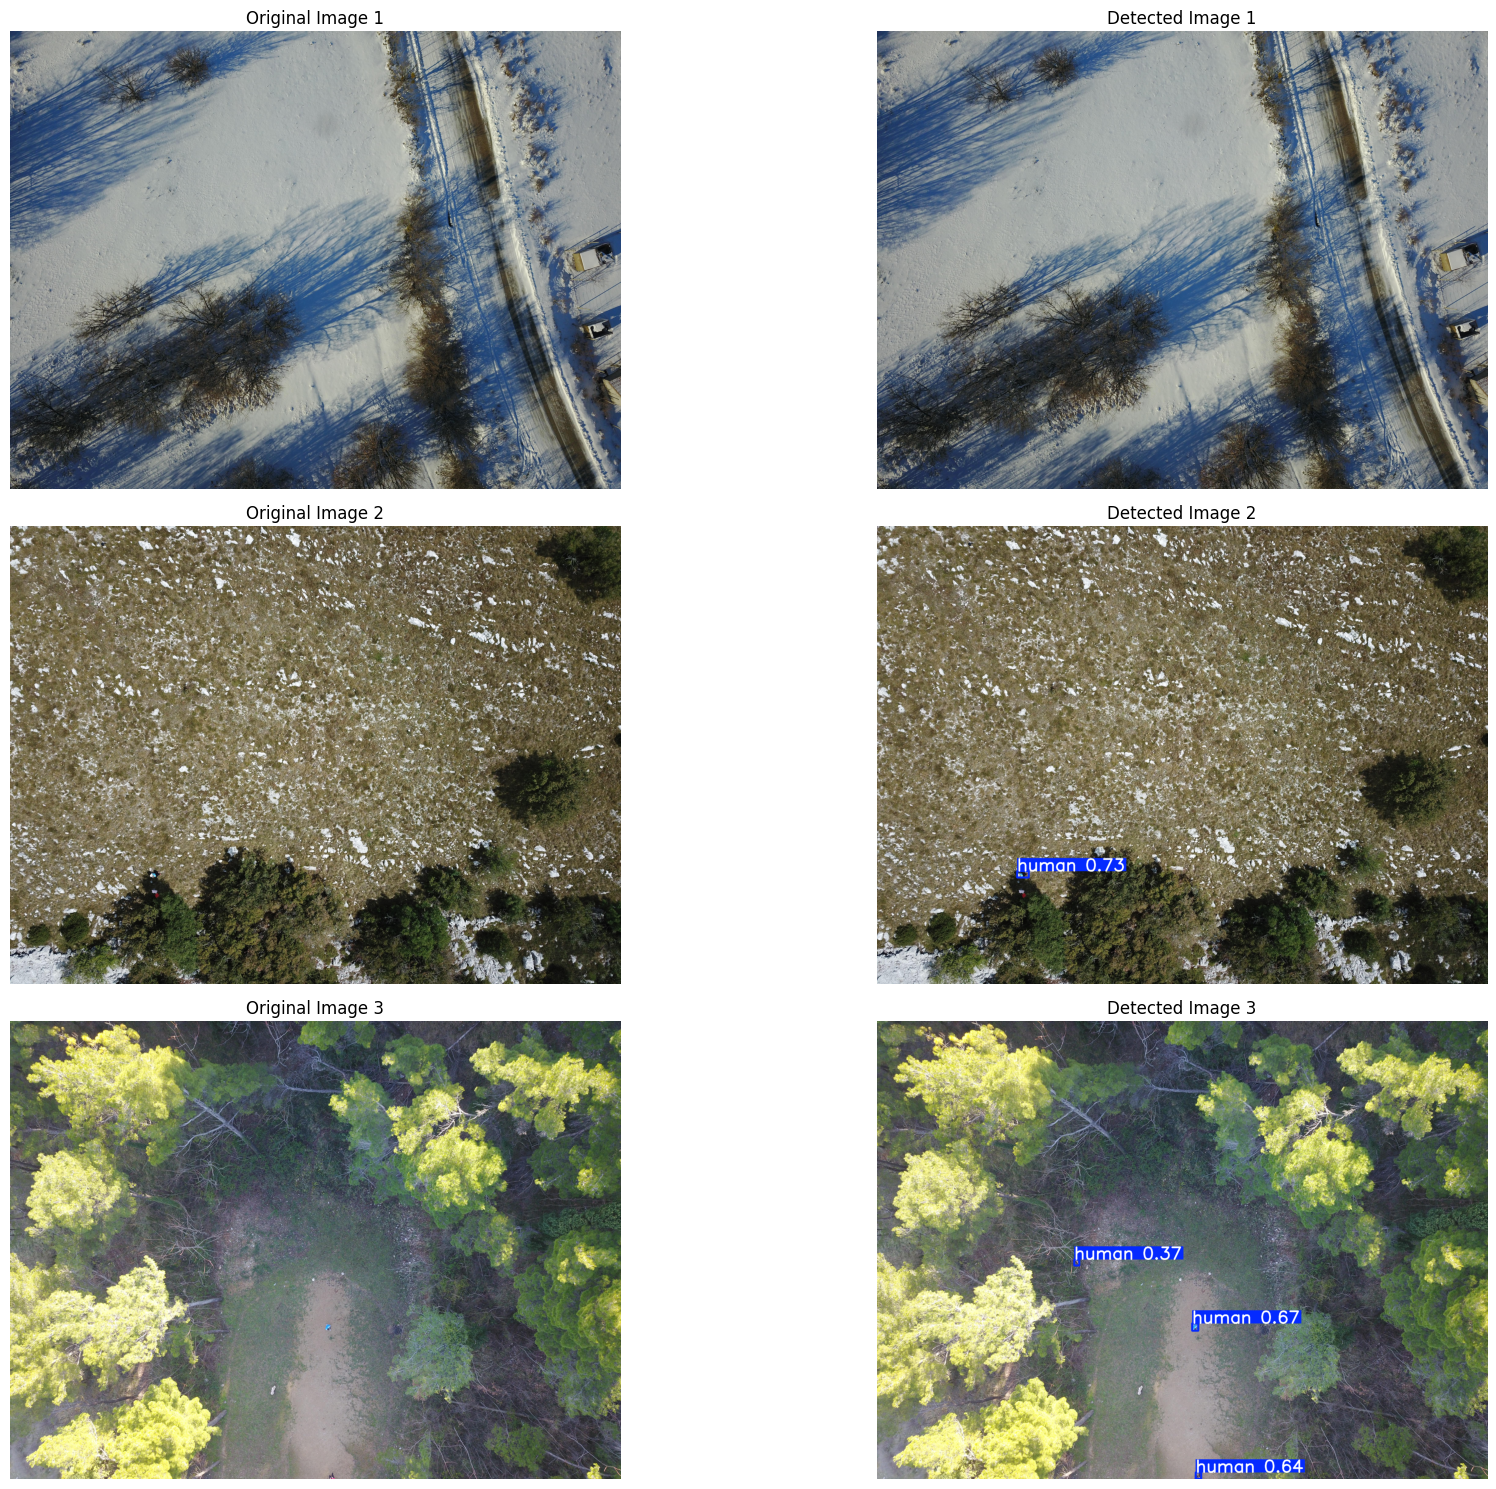

In [17]:
val_images = [os.path.join(VAL_DATA_DIR, f) for f in os.listdir(VAL_DATA_DIR) if f.endswith('.jpg')][:3]
val_labels = [os.path.join(LABELS_DIR_VAL, f) for f in os.listdir(LABELS_DIR_VAL) if f.endswith('.txt')][:3]

rm_folder_if_exists('./runs/detect/val2')

plt.figure(figsize=(20, 15))
for i, img_path in enumerate(val_images):
    results = best_model(img_path)
    
    plt.subplot(3, 2, 2*i+1)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = draw_yolo_labels(img, val_labels[i], imgsz=1024)
    plt.imshow(img)
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(3, 2, 2*i+2)
    detected_img = results[0].plot()
    detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
    plt.imshow(detected_img)
    plt.title(f'Detected Image {i+1}')
    plt.axis('off')

    with open(val_labels[i], 'r') as lbl_file:
        print(lbl_file.read())

plt.tight_layout()
plt.show()